In [12]:
import glob
import os 

import requests 

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
rv_path = "./computed/realised_variance"
glob.glob(f"{rv_path}/*.csv")

['./computed/realised_variance/chi_rvs.csv',
 './computed/realised_variance/us_rvs.csv',
 './computed/realised_variance/jpn_rvs.csv',
 './computed/realised_variance/che_rvs.csv']

In [3]:
jpn_rvs = pd.read_csv(f"{rv_path}/jpn_rvs.csv", parse_dates=[0], index_col=0)
us_rvs = pd.read_csv(f"{rv_path}/us_rvs.csv", parse_dates=[0], index_col=0)
che_rvs = pd.read_csv(f"{rv_path}/che_rvs.csv", parse_dates=[0], index_col=0)
chi_rvs = pd.read_csv(f"{rv_path}/chi_rvs.csv", parse_dates=[0], index_col=0)

### Visualisation of RVs

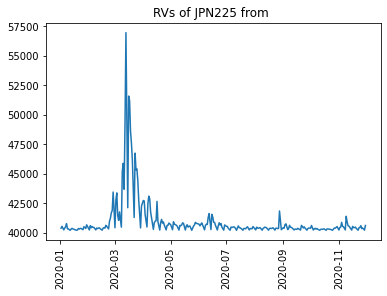

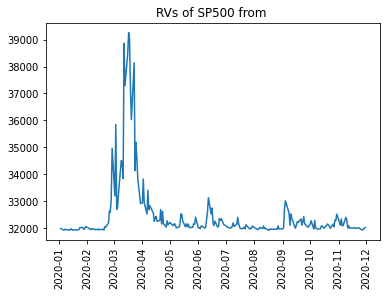

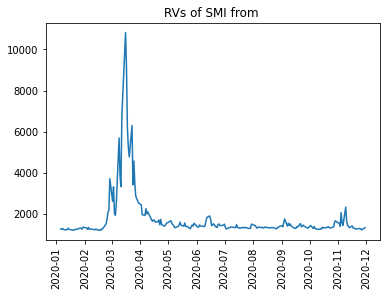

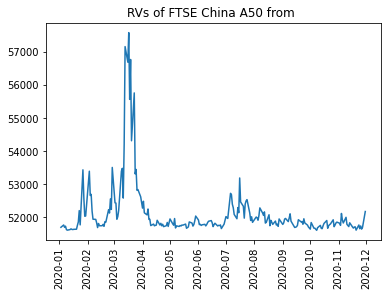

In [19]:
dfs_rvs = [jpn_rvs, us_rvs, che_rvs, chi_rvs]
indices = ["JPN225", "SP500", "SMI", "FTSE China A50"]
for i in range(len(dfs_rvs)):
    df = dfs_rvs[i]
    #keep_up_to = 150 # keep latest n dates of timeseries
    keep_up_to = None # keep all dates
    plt.figure()
    plt.plot(df.index[:keep_up_to], df.RV.loc[df.index[:keep_up_to]])
    plt.xticks(rotation=90)
    plt.title(f"RVs of {indices[i]} from ")
    plt.show()

### Comparison with COVID data

In [7]:
# compare RVs with covid data
from granger_causality_functions import scale_data, plot_time_series, plot_correlation_matrix, make_stationary
from granger_causality_functions import grangers_causality_matrix, network_granger, granger_causality

In [31]:
# redownload covid and put in folder
countries_of_interest = ["USA", "CHE", "JPN", "CHN"]

endpoint = "https://covidapi.info/api/v1" # endpoint that provides JHU data
start_date = "2020-01-01"
end_date = "2020-12-01" 
dfs = {} # dfs of cumulative confirmed cases
covid_path = "./datasets/covid"
for country in countries_of_interest:
    if os.path.isfile(f"datasets/covid/{country}.csv"):
        df = pd.read_csv(f"datasets/covid/{country}.csv", index_col=["date"])
    else:
        query = f"{endpoint}/country/{country}/timeseries/{start_date}/{end_date}"
        res = requests.get(query).json()
        df = pd.DataFrame(res["result"]).set_index("date")
        df.index = pd.DatetimeIndex(df.index)
        df["ts_in_secs"] = df.index.astype(int)
        df["new_confirmed"] = df["confirmed"].diff().fillna(0)
        df.to_csv(f"{covid_path}/{country}.csv")
        
    dfs[country] = df

In [32]:
dfs["USA"].head(10)

,confirmed,deaths,recovered,ts_in_secs,new_confirmed
date,,,,,
2020-01-22,1,0,0,1579651200000000000,0.0
2020-01-23,1,0,0,1579737600000000000,0.0
2020-01-24,2,0,0,1579824000000000000,1.0
2020-01-25,2,0,0,1579910400000000000,0.0
2020-01-26,5,0,0,1579996800000000000,3.0
2020-01-27,5,0,0,1580083200000000000,0.0
2020-01-28,5,0,0,1580169600000000000,0.0
2020-01-29,6,0,0,1580256000000000000,1.0
2020-01-30,6,0,0,1580342400000000000,0.0


STATIONARY TEST: 

 Dickey-Fuller Stationary Test for "RV" 
 -----------------------------------------------
 Null Hypothesis: Data are Non-Stationary.
 Significance level   = 0.05
 Test Statistics      = -2.332
 No. Lags Chosen      = 16
 Critical value 1%     = -3.458
 Critical value 5%     = -2.874
 Critical value 10%    = -2.573
 => P-Value = 0.1618. Weak evidence to reject H0.
 => Series in Non-Stationary


 Dickey-Fuller Stationary Test for "new_confirmed" 
 -----------------------------------------------
 Null Hypothesis: Data are Non-Stationary.
 Significance level   = 0.05
 Test Statistics      = -3.5149
 No. Lags Chosen      = 7
 Critical value 1%     = -3.457
 Critical value 5%     = -2.873
 Critical value 10%    = -2.573
 => P-Value = 0.0076. Rejecting H0.
 => Series is Stationary




/home/hienle/.virtualenvs/notebook/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/home/hienle/.virtualenvs/notebook/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/home/hienle/.virtualenvs/notebook/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:304: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/home

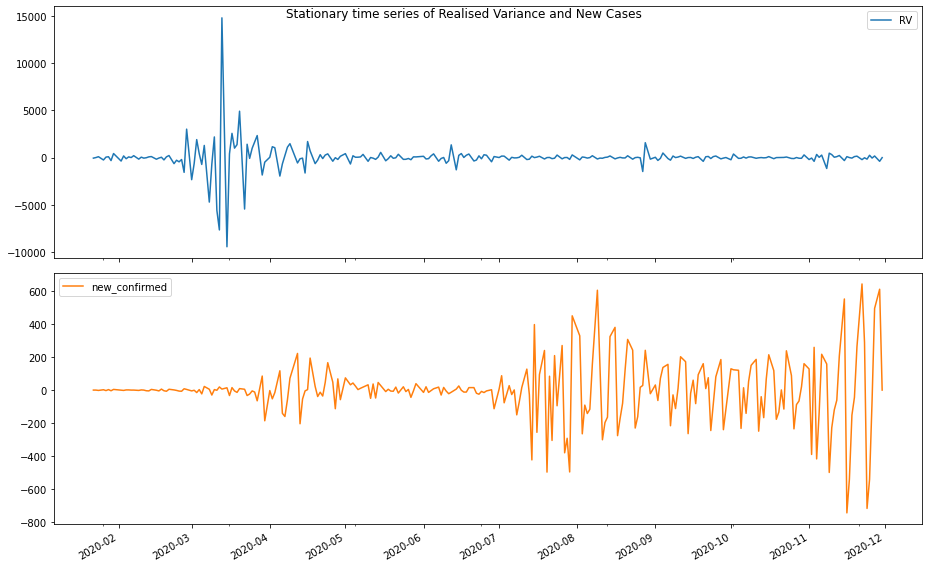


GRANGER CAUSALITY MATRIX: 



,RV_x,new_confirmed_x
RV_y,0.0,0.285
new_confirmed_y,0.646,0.0


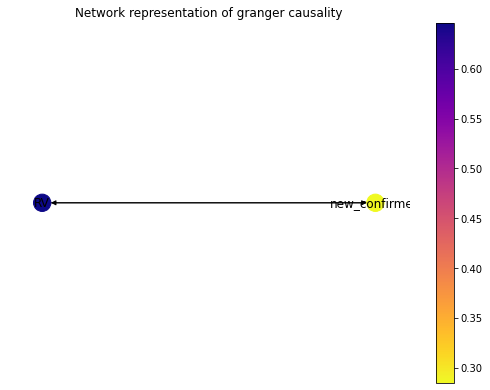

,RV_x,new_confirmed_x
RV_y,0.000,0.285
new_confirmed_y,0.646,0.000


In [43]:
# compare each country's index's RVs with their respective COVID dynamic
granger_vars = ["RV", "new_confirmed"]
jpn_merged = pd.merge(jpn_rvs[["RV"]], dfs["JPN"][["new_confirmed"]], how="inner", left_index=True,
                      right_index=True)
granger_causality(jpn_merged, granger_vars, "Realised Variance and New Cases")

STATIONARY TEST: 

 Dickey-Fuller Stationary Test for "RV" 
 -----------------------------------------------
 Null Hypothesis: Data are Non-Stationary.
 Significance level   = 0.05
 Test Statistics      = -2.7776
 No. Lags Chosen      = 10
 Critical value 1%     = -3.463
 Critical value 5%     = -2.876
 Critical value 10%    = -2.575
 => P-Value = 0.0615. Weak evidence to reject H0.
 => Series in Non-Stationary


 Dickey-Fuller Stationary Test for "new_confirmed" 
 -----------------------------------------------
 Null Hypothesis: Data are Non-Stationary.
 Significance level   = 0.05
 Test Statistics      = -5.0293
 No. Lags Chosen      = 6
 Critical value 1%     = -3.463
 Critical value 5%     = -2.876
 Critical value 10%    = -2.574
 => P-Value = 0.0. Rejecting H0.
 => Series is Stationary




/home/hienle/.virtualenvs/notebook/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/home/hienle/.virtualenvs/notebook/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/home/hienle/.virtualenvs/notebook/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:304: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/home

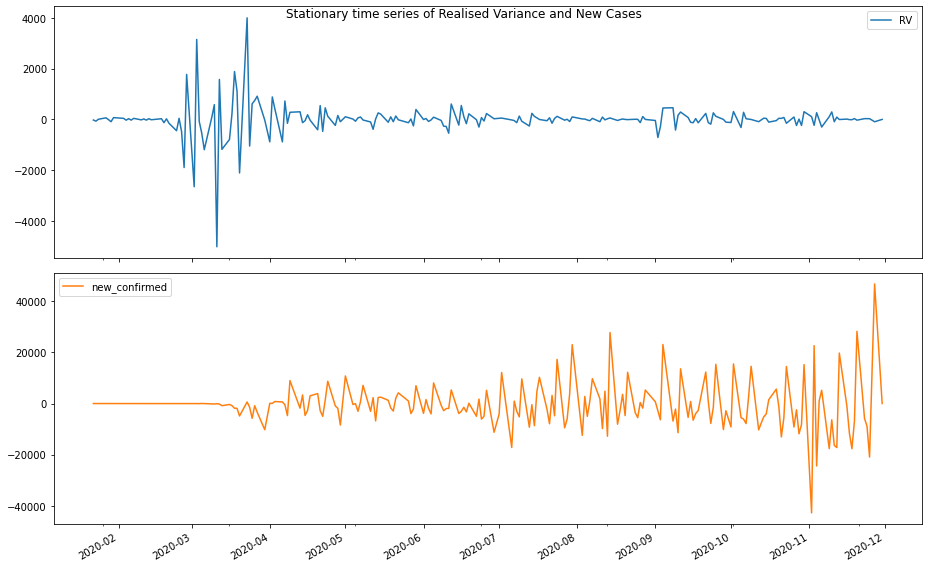


GRANGER CAUSALITY MATRIX: 



,RV_x,new_confirmed_x
RV_y,0.0,0.488
new_confirmed_y,0.559,0.0


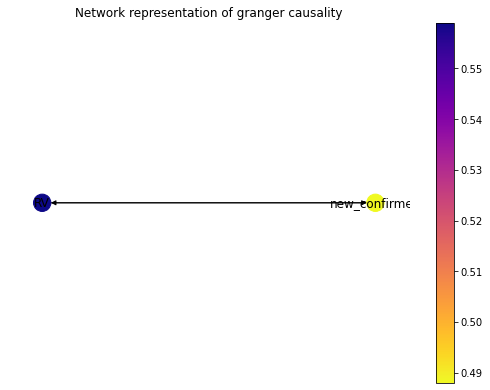

,RV_x,new_confirmed_x
RV_y,0.000,0.488
new_confirmed_y,0.559,0.000


In [44]:
us_merged = pd.merge(us_rvs[["RV"]], dfs["USA"][["new_confirmed"]], how="inner", left_index=True,
                      right_index=True)
granger_causality(us_merged, granger_vars, "Realised Variance and New Cases")

STATIONARY TEST: 

 Dickey-Fuller Stationary Test for "RV" 
 -----------------------------------------------
 Null Hypothesis: Data are Non-Stationary.
 Significance level   = 0.05
 Test Statistics      = -2.8409
 No. Lags Chosen      = 12
 Critical value 1%     = -3.464
 Critical value 5%     = -2.876
 Critical value 10%    = -2.575
 => P-Value = 0.0527. Weak evidence to reject H0.
 => Series in Non-Stationary


 Dickey-Fuller Stationary Test for "new_confirmed" 
 -----------------------------------------------
 Null Hypothesis: Data are Non-Stationary.
 Significance level   = 0.05
 Test Statistics      = -3.0063
 No. Lags Chosen      = 11
 Critical value 1%     = -3.463
 Critical value 5%     = -2.876
 Critical value 10%    = -2.575
 => P-Value = 0.0343. Rejecting H0.
 => Series is Stationary




/home/hienle/.virtualenvs/notebook/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/home/hienle/.virtualenvs/notebook/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/home/hienle/.virtualenvs/notebook/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:304: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/home

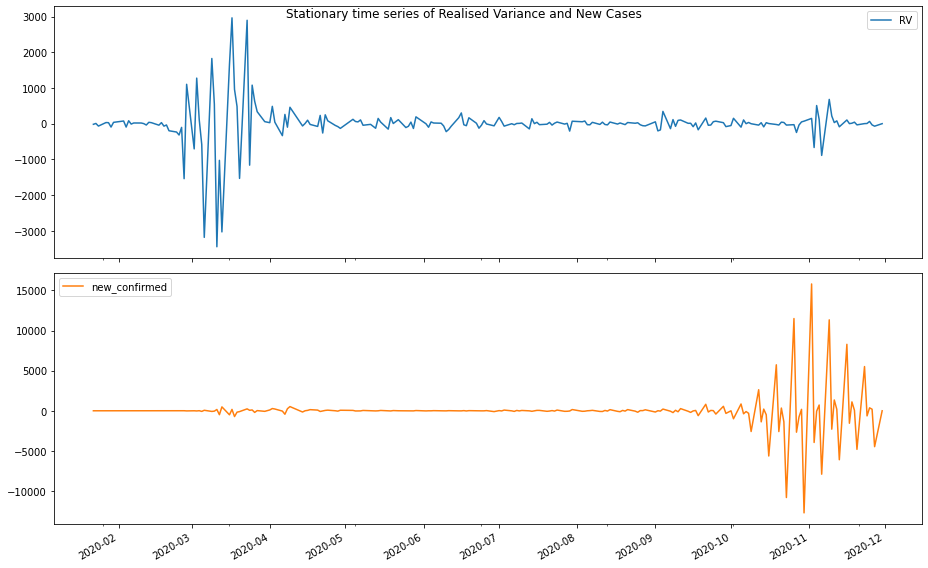


GRANGER CAUSALITY MATRIX: 



,RV_x,new_confirmed_x
RV_y,0.0,0.564
new_confirmed_y,0.379,0.0


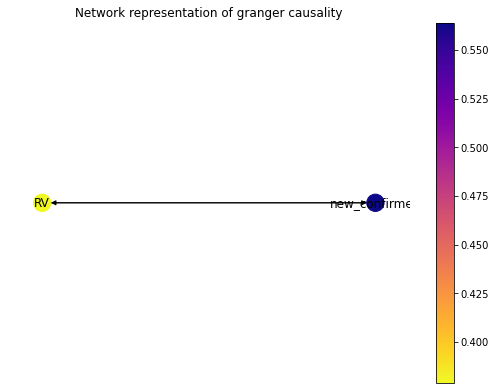

,RV_x,new_confirmed_x
RV_y,0.000,0.564
new_confirmed_y,0.379,0.000


In [45]:
che_merged = pd.merge(che_rvs[["RV"]], dfs["CHE"][["new_confirmed"]], how="inner", left_index=True,
                      right_index=True)
granger_causality(che_merged, granger_vars, "Realised Variance and New Cases")

STATIONARY TEST: 

 Dickey-Fuller Stationary Test for "RV" 
 -----------------------------------------------
 Null Hypothesis: Data are Non-Stationary.
 Significance level   = 0.05
 Test Statistics      = -3.0888
 No. Lags Chosen      = 12
 Critical value 1%     = -3.463
 Critical value 5%     = -2.876
 Critical value 10%    = -2.574
 => P-Value = 0.0274. Rejecting H0.
 => Series is Stationary


 Dickey-Fuller Stationary Test for "new_confirmed" 
 -----------------------------------------------
 Null Hypothesis: Data are Non-Stationary.
 Significance level   = 0.05
 Test Statistics      = -4.0339
 No. Lags Chosen      = 3
 Critical value 1%     = -3.461
 Critical value 5%     = -2.875
 Critical value 10%    = -2.574
 => P-Value = 0.0012. Rejecting H0.
 => Series is Stationary




/home/hienle/.virtualenvs/notebook/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/home/hienle/.virtualenvs/notebook/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/home/hienle/.virtualenvs/notebook/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:304: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/home

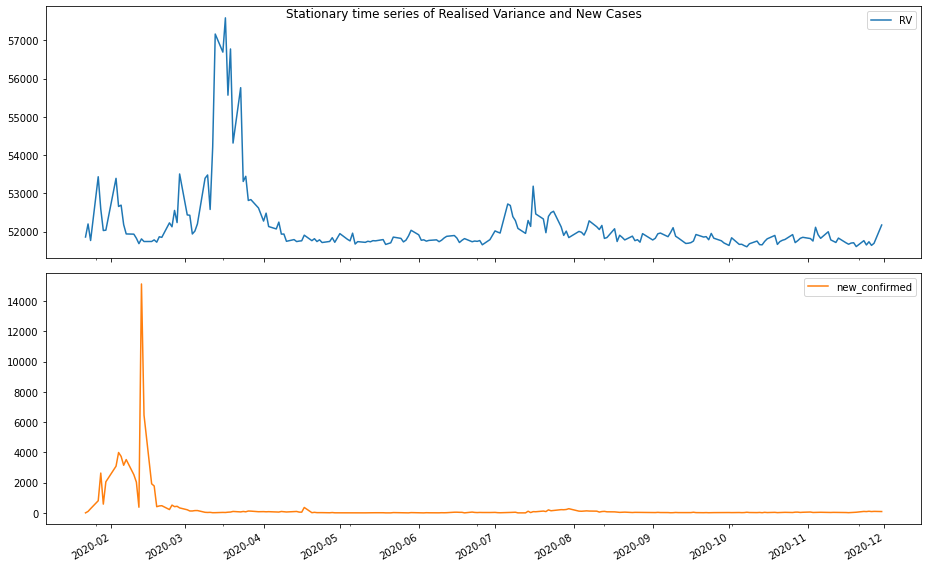


GRANGER CAUSALITY MATRIX: 



,RV_x,new_confirmed_x
RV_y,0.0,0.0
new_confirmed_y,0.184,0.0


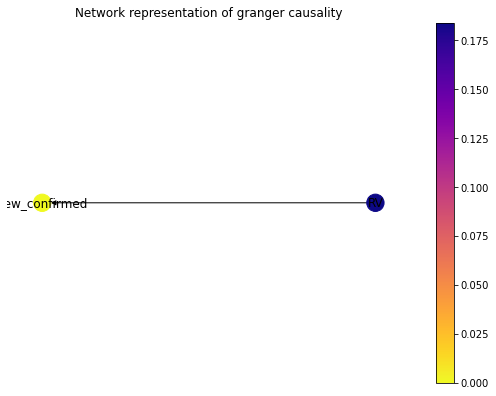

,RV_x,new_confirmed_x
RV_y,0.000,0.0
new_confirmed_y,0.184,0.0


In [47]:
chi_merged = pd.merge(chi_rvs[["RV"]], dfs["CHN"][["new_confirmed"]], how="inner", left_index=True,
                      right_index=True)
granger_causality(chi_merged, granger_vars, "Realised Variance and New Cases")

### Divide in periods of lockdown

In [ ]:
# Japan: 7th April - 25th May
# China: 23rd Jan - 10th March
# Switzerland:  17th March - 27th April

